In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf


imports work
imports work


In [6]:
# hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)
hit_data_scope_1093 = sf.DUT_TELE_merge(1093)

In [2]:
hit_data_1493 = sf.get_ROOT_data_zip_Aligned(1493)

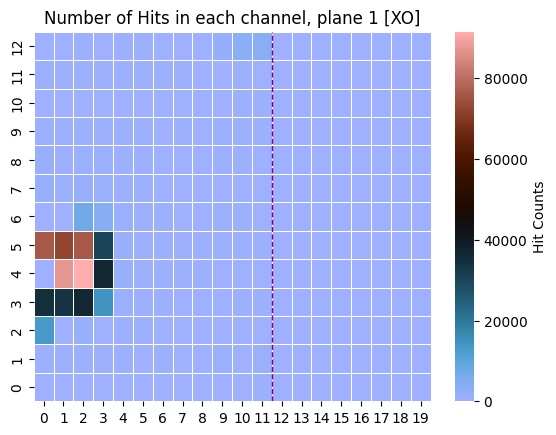

In [20]:
rf.hits_amount_colormap_single_plane(hit_data_1493.hits,1)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

1493 -tungsten only

In [59]:
# colormap of the average showeer energy for its scope position
def avg_energy_scope_colormap(data, x_borders="false", y_borders="false", cmap="tab20c", bins=300):

    X_scope1 = ak.flatten(data.tele.x)
    Y_scope1 = ak.flatten(data.tele.y)

    X_scope = -ak.to_numpy(X_scope1)
    Y_scope = ak.to_numpy(Y_scope1)

    amp1 = ak.sum(data.hits.amp[data.hits.plane == 1], axis = 1)
    # amp1 = ak.sum(data.hits.amp, axis = 1)
    amp = ak.to_numpy(amp1)

    # Histogram of SUM of amplitudes
    sum_amp, xedges, yedges = np.histogram2d(X_scope, Y_scope, bins=bins, weights=amp)
    # sum_amp = np.where(np.isfinite(sum_amp) & (sum_amp <= 200), sum_amp, 0)


    # Histogram of COUNTS
    counts, _, _ = np.histogram2d(X_scope, Y_scope, bins=[xedges, yedges])

    # Avoid division by zero
    avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

    # Plot
    plt.figure(figsize=(6,5))
    plt.pcolormesh(xedges, yedges, avg_amp.T, cmap=cmap)  
    plt.colorbar(label="Average Amplitude")
    plt.xlim(min(X_scope), max(X_scope))
    plt.ylim(min(Y_scope), max(Y_scope))
    
    if x_borders != "false":
        plt.xlim(-x_borders, x_borders)
    if y_borders != "false":
        plt.ylim(-y_borders, y_borders)
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.title("Average Shower Energy per Position")
    plt.show()


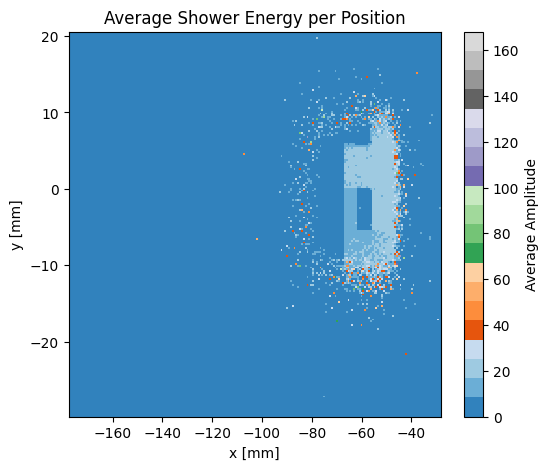

In [60]:
avg_energy_scope_colormap(hit_data_1493, bins=200, cmap="tab20c")

In [81]:
# plots the energy profile vs the x axis and fits to gaussian
def E_vs_X_scope_gaussian_fit(hit_data, chi2, y_min=-10, y_max=10, x_min=-20, x_max=20, bin_size = 0.4, return_param=False):

    # filter data by chi2
    hit_data_chi2 = sf.filter_chi2_scope_data(hit_data, 1/chi2, chi2)
    y_max, y_min

    # take the data from the seletced y range
    data = hit_data_chi2[ak.flatten((hit_data_chi2.tele.y < y_max) & (hit_data_chi2.tele.y > y_min))]
    data = data[ak.num(data.tele) > 0]


    # compute X and E
    X1 = -ak.to_numpy(ak.mean(data.tele.x, axis=1))
    X = bin_size * np.round(X1 / bin_size)
    # E = ak.sum(data.hits.amp, axis=1)
    E = ak.sum(data.hits.amp[data.hits.plane == 1], axis = 1)


    # grouping
    amp, mean, pos = rf.ak_groupby(X, E, round="false")

    # statistics
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # choose the range of X
    mask = (pos > x_min) & (pos < x_max)

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    # Fitting

    #  Gaussian model 
    def gaussian_linear(x, c, m, A, mu, sigma):
        return c + m*x - A * np.exp(-(x - mu)**2 / (2 * sigma**2))

    # initial guesses
    c0 = 6000
    m0 = 0
    A0 = np.min(amp_m)
    # mu0 = pos_m[np.argmin(amp_m)]
    mu0 = 0
    sigma0 = 3
    # sigma0 = (np.max(pos_m) - np.min(pos_m)) / 6

    # fit
    popt, pcov = curve_fit(gaussian_linear, pos_m, amp_m, p0=[c0, m0, A0, mu0, sigma0])

    # fitted values
    c_fit, m_fit, A_fit, mu_fit, sigma_fit = popt
    
    # uncertainties
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties
    c_err, m_err, A_err, mu_err, sigma_err = perr

    # return the fitting results if needed
    if return_param:
        return popt, perr

    # slope and uncertainty of the fitted function
    theta_fit = np.arctan(m_fit)
    theta_err = m_err / (1.0 + m_fit**2)


    # chi2
    residuals = amp_m - gaussian_linear(pos_m, *popt)

    # avoid division by zero if any std are 0
    mask_err = err_m > 0
    chi2_val = np.sum((residuals[mask_err] / err_m[mask_err])**2)

    # number of points used in chi2
    N = np.sum(mask_err)
    
    # number of fit params (c, m, A, mu, sigma) = 5
    p = len(popt)
    ndof = N - p
    chi2_ndof = chi2_val / ndof if ndof > 0 else np.nan


    print("Gaussian fit parameters:")
    print(f"c     = {c_fit:.3f}")
    print(f"m     = {m_fit:.3f}")
    print(f"theta     = {np.arctan(m_fit):.3f} Radians")
    print(f"A     = {A_fit:.3f}")
    print(f"mu    = {mu_fit:.3f}")
    print(f"sigma = {sigma_fit:.3f}")


    # plot
    fig, ax = plt.subplots()
    ax.errorbar(pos_m, amp_m, yerr=err_m, fmt='.', capsize=4, label="data")

    # make a smooth fitted function
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = gaussian_linear(x_fit, *popt)
    # ax.plot(x_fit, y_fit, 'r-', label="Gaussian fit", zorder=10)

    # # build textbox string
    # textstr = "\n".join([
    #     r"$\chi^2/\mathrm{ndof} = %.2f$" % chi2_ndof,
    #     r"$c = %.3f \pm %.3f$" % (c_fit, c_err),
    #     r"$m = %.3f \pm %.3f$" % (m_fit, m_err),
    #     r"$\theta = %.3f \pm %.3f$ rad" % (theta_fit, theta_err),
    #     r"$A = %.3f \pm %.3f$" % (A_fit, A_err),
    #     r"$\mu = %.3f \pm %.3f$" % (mu_fit, mu_err),
    #     r"$\sigma = %.3f \pm %.3f$" % (sigma_fit, sigma_err),
    # ])

    # # add textbox (axes coordinates: 0..1)
    # ax.text(
    #     0.65, 0.36, textstr,
    #     transform=ax.transAxes,
    #     fontsize=10,
    #     verticalalignment="top",
    #     bbox=dict(boxstyle="round,pad=0.4", facecolor="pink", alpha=0.8, edgecolor="0.5")
    # )


    ax.grid(True)
    ax.set_xlabel("X Scope")
    ax.set_ylabel("Energy [ADC] (avg ± std)")
    # ax.set_title(r"Average Energy vs Scope X Position \n Fit to $y = m \cdot x + c - A\cdot e^{\frac{-(x - \mu)^2}{(2 \sigma^2)}}$")
    ax.set_title("Average Energy vs Scope X Position")

    ax.legend(loc="upper left")
    # leg = ax.legend(loc="upper right", title=textstr, frameon=True)
    plt.show()





Gaussian fit parameters:
c     = 1064.141
m     = 15.694
theta     = 1.507 Radians
A     = 0.307
mu    = 0.000
sigma = 3.000


C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
C:\Users\bents\AppData\Local\Temp\ipykernel_5284\2601605081.py:51: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian_linear, pos_m, amp_m, p0=[c0, m0, A0, mu0, sigma0])


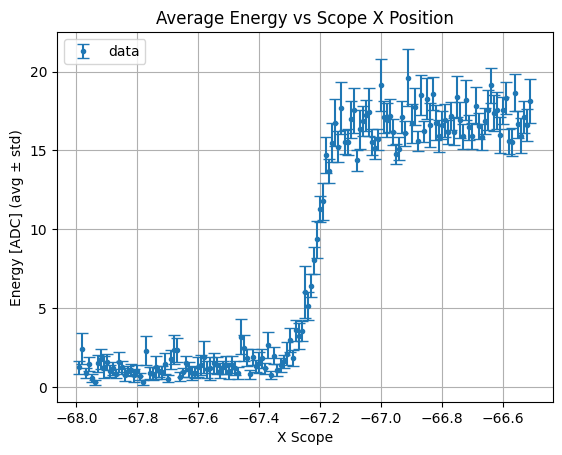

In [84]:
ymin = 1
E_vs_X_scope_gaussian_fit(hit_data_1493, 10, ymin, ymin+4, -68, -66.5, bin_size=0.01)

In [5]:
path = "TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco_diagnostics.root"
scope_data_1088_corrected = rf.reconstruct_data_all_dead_pads(scope_data_1088, 5, path)

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_24644\2696076564.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco_diagnostics.root"


shower center: 112
we got the data
amount of dead channels: 140
{plane_ID: 1, channel_ID: 77}
48 channels left
{plane_ID: 1, channel_ID: 133}
47 channels left
{plane_ID: 2, channel_ID: 32}
46 channels left
{plane_ID: 2, channel_ID: 50}
45 channels left
{plane_ID: 2, channel_ID: 54}
44 channels left
{plane_ID: 2, channel_ID: 67}
43 channels left
{plane_ID: 2, channel_ID: 77}
42 channels left
{plane_ID: 2, channel_ID: 148}
41 channels left
{plane_ID: 2, channel_ID: 172}
40 channels left
{plane_ID: 2, channel_ID: 173}
39 channels left
{plane_ID: 2, channel_ID: 174}
38 channels left
{plane_ID: 2, channel_ID: 175}
37 channels left
{plane_ID: 2, channel_ID: 176}
36 channels left
{plane_ID: 2, channel_ID: 177}
35 channels left
{plane_ID: 2, channel_ID: 192}
34 channels left
{plane_ID: 2, channel_ID: 193}
33 channels left
{plane_ID: 2, channel_ID: 195}
32 channels left
{plane_ID: 2, channel_ID: 212}
31 channels left
{plane_ID: 2, channel_ID: 213}
30 channels left
{plane_ID: 2, channel_ID: 217}